In [9]:
import os
import time

import torch 
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchaudio

import matplotlib.pyplot as plt
import numpy as np

from dataPrep import MTATDataset
from model import SingleExtractor

In [10]:
device = torch.device(0)

In [11]:
styEncoder = SingleExtractor(conv_channels=128,
                             sample_rate=16000,
                             n_fft=513,
                             n_harmonic=6,
                             semitone_scale=2,
                             learn_bw='only_Q').to(device)

In [13]:
# ! ls checkpoints/
! ls best_models/

cos_0.5.pth  cos_1.0.pth  cos_1.5.pth  l2_15.pth  l2_20.pth


In [14]:
styEncoder.load_state_dict(torch.load('best_models/cos_1.0.pth'))

<All keys matched successfully>

In [21]:
pos_dir = '../Data/spectrogram_pos/'
neg_dir = '../Data/spectrogram_neg/'

audio_embeddings = []
audio_labels = []

for file in os.listdir(pos_dir):
    file_path = os.path.join(pos_dir, file)
    spec = np.load(file_path)
    emb = styEncoder(Variable(torch.tensor(spec).unsqueeze(0)).to(device)).cpu().detach().numpy().flatten()
    # print (emb.shape)
    audio_embeddings.append(emb)
    audio_labels.append(1)

for file in os.listdir(neg_dir):
    file_path = os.path.join(neg_dir, file)
    spec = np.load(file_path)
    emb = styEncoder(Variable(torch.tensor(spec).unsqueeze(0)).to(device)).cpu().detach().numpy().flatten()
    # print (emb.shape)
    audio_embeddings.append(emb)
    audio_labels.append(2)

In [22]:
audio_embeddings = np.array(audio_embeddings)
audio_labels = np.array(audio_labels)

In [24]:
# calculate distance matrix
def calculateCosineDistMat(data):
    num = len(data)
    dist = np.zeros((num, num))
    for i in range(num):
        for j in range(i+1):
            if i == j:
                dist[i, j] = .0
                continue
            cosSim = np.dot(audio_embeddings[i], audio_embeddings[j])/(np.linalg.norm(audio_embeddings[i]) * np.linalg.norm(audio_embeddings[j]))
            d = 10/(1+np.exp(10*cosSim))
            dist[i, j] = d
            dist[j, i] = d
    return dist

def calculateEuclideanDistMat(data):
    num = len(data)
    dist = np.zeros((num, num))
    for i in range(num):
        for j in range(i+1):
            if i == j:
                dist[i, j] = .0
                continue
            d = np.linalg.norm(data[i] - data[j])
            dist[i, j] = d
            dist[j, i] = d
    return dist

dist_mat = calculateCosineDistMat(audio_embeddings)
# dist_mat = calculateEuclideanDistMat(audio_embeddings)

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, metric='precomputed', perplexity=50)
X_emb = tsne.fit_transform(dist_mat)

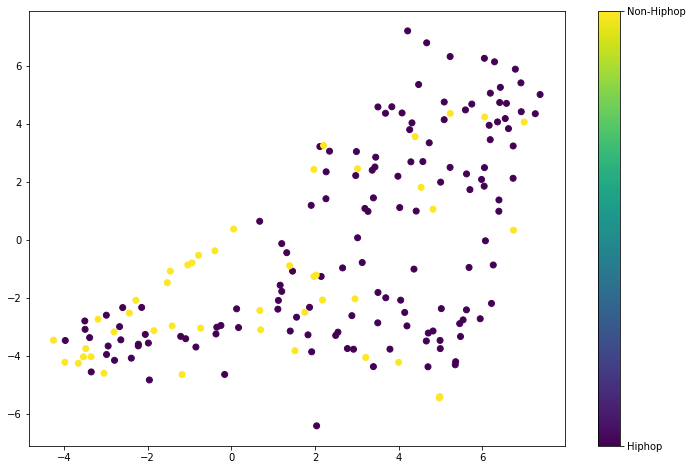

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=audio_labels)
cb = plt.colorbar()
cb.set_ticks(np.arange(1,3))
cb.set_ticklabels(['Hiphop', 'Non-Hiphop'])